In [1]:
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import DataLoader
from sklearn import preprocessing

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
device

'cpu'

In [3]:
#based on https://towardsdatascience.com/build-a-simple-neural-network-using-pytorch-38c55158028d
n_input, n_hidden, n_hidden2, n_out, batch_size, learning_rate, momentum, num_workers = 9, 15, 10, 2, 32, 0.001, 0.99, 0

In [4]:
full_pd = pd.read_csv('237k.csv')
full_tensor = torch.tensor(full_pd.to_numpy()).float()
full_tensor[:10, :]
full_pd.shape

(237484, 11)

In [5]:
scaler = preprocessing.MinMaxScaler()

In [6]:
full_scaled = torch.tensor(scaler.fit_transform(full_tensor)).float()
full_scaled[:10, :]

tensor([[0.0000e+00, 0.0000e+00, 1.4286e-01, 1.4286e-01, 3.1193e-01, 4.0891e-01,
         7.9886e-01, 7.3915e-01, 3.0244e-03, 5.5611e-02, 5.8032e-01],
        [4.2857e-01, 0.0000e+00, 2.8571e-01, 5.7143e-01, 3.7063e-01, 4.2484e-01,
         8.6386e-01, 7.3438e-01, 4.4560e-04, 1.0000e+00, 5.4318e-03],
        [2.8571e-01, 8.5714e-01, 0.0000e+00, 8.5714e-01, 6.6664e-02, 6.9349e-01,
         5.0336e-01, 6.1156e-01, 4.1963e-05, 1.0000e+00, 5.3588e-03],
        [1.4286e-01, 7.1429e-01, 7.1429e-01, 1.4286e-01, 5.7649e-02, 9.4421e-01,
         5.6026e-01, 7.1128e-01, 3.8886e-04, 1.0000e+00, 5.4436e-03],
        [2.8571e-01, 0.0000e+00, 5.7143e-01, 5.7143e-01, 3.2106e-01, 3.5409e-01,
         5.8771e-01, 6.2953e-01, 1.2502e-03, 6.7290e-01, 1.2079e-01],
        [4.2857e-01, 1.4286e-01, 4.2857e-01, 4.2857e-01, 9.0662e-01, 2.9580e-01,
         1.0988e-01, 4.7156e-01, 1.6752e-02, 8.0884e-01, 1.0302e-01],
        [7.1429e-01, 1.0000e+00, 0.0000e+00, 8.5714e-01, 4.1767e-01, 8.2794e-01,
         6.98

In [7]:
train_n = {"data": full_scaled[:80000, :9].to(device), "target": full_scaled[:80000, 9:].to(device)}
test_n = {"data": full_scaled[:-10000, :9].to(device), "target": full_scaled[:-10000, 9:].to(device)}

test_n["data"].requires_grad=False
test_n["target"].requires_grad=False

train, validate, test = torch.utils.data.random_split(full_scaled, [200000, 27484, 10000])
#train, validate, test = torch.utils.data.random_split(full_scaled, [80000, 14765, 10000])
train_loader = DataLoader(train, batch_size=batch_size, num_workers=num_workers, pin_memory=True)

In [8]:
model = nn.Sequential(nn.Linear(9, 15),
                      nn.ReLU(),
                      nn.Linear(15, 10),
                      nn.ReLU(),
                      nn.Linear(10, 2),
                      nn.Sigmoid())
model.to(device)
print(model)

Sequential(
  (0): Linear(in_features=9, out_features=15, bias=True)
  (1): ReLU()
  (2): Linear(in_features=15, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=2, bias=True)
  (5): Sigmoid()
)


In [9]:
loss_function = nn.HuberLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

In [10]:
#torch.multiprocessing.set_start_method('spawn')
import time

tim = time.time()

losses = []
test_losses = []
for i in range(15):
    for j, item in enumerate(train_loader):
        train_x, train_y = item[:, :9], item[:, 9:]
        
        train_x = train_x.to(device)
        train_y = train_y.to(device)
        
        pred_y = model(train_x)
        loss = loss_function(pred_y, train_y)
        losses.append(loss.item())

        model.zero_grad()
        loss.backward()

        optimizer.step()
        
    test_pred_y = model(test_n["data"])
    test_loss = loss_function(test_pred_y, test_n["target"])
    test_losses.append(test_loss)
    
print(time.time() - tim)

64.53242421150208


In [11]:
#losses = []
#test_losses = []
#for i in range(100):
#    for j in range(0, train_n["data"].shape[0], batch_size):
#        train_x, train_y = train_n["data"][j:j+batch_size], train_n["target"][j:j+batch_size]
#        
#        pred_y = model(train_x)
#        loss = loss_function(pred_y, train_y)
#        losses.append(loss.item())
#
#        model.zero_grad()
#        loss.backward()
#
#        optimizer.step()
#
#    test_pred_y = model(test_n["data"])
#    test_loss = loss_function(test_pred_y, test_n["target"])
#    test_losses.append(test_loss)

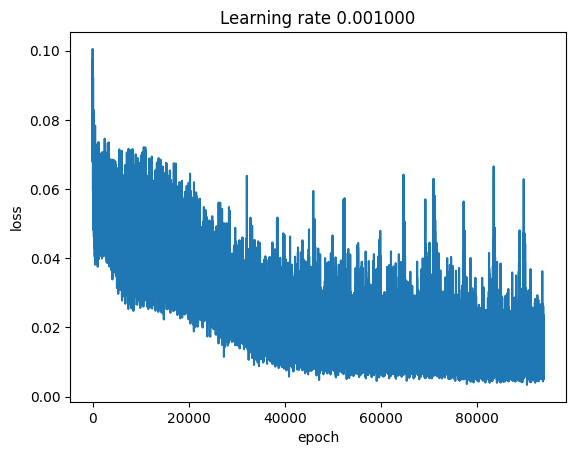

In [12]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title("Learning rate %f"%(learning_rate))
plt.show()

In [13]:
test_losses

[tensor(0.0462, grad_fn=<HuberLossBackward0>),
 tensor(0.0440, grad_fn=<HuberLossBackward0>),
 tensor(0.0398, grad_fn=<HuberLossBackward0>),
 tensor(0.0319, grad_fn=<HuberLossBackward0>),
 tensor(0.0256, grad_fn=<HuberLossBackward0>),
 tensor(0.0215, grad_fn=<HuberLossBackward0>),
 tensor(0.0188, grad_fn=<HuberLossBackward0>),
 tensor(0.0174, grad_fn=<HuberLossBackward0>),
 tensor(0.0154, grad_fn=<HuberLossBackward0>),
 tensor(0.0152, grad_fn=<HuberLossBackward0>),
 tensor(0.0143, grad_fn=<HuberLossBackward0>),
 tensor(0.0136, grad_fn=<HuberLossBackward0>),
 tensor(0.0134, grad_fn=<HuberLossBackward0>),
 tensor(0.0131, grad_fn=<HuberLossBackward0>),
 tensor(0.0120, grad_fn=<HuberLossBackward0>)]

In [14]:
#                                      bandwidth ↓
model(torch.tensor([1., 1., 1., 1., 1., 1., 1., 100., 1.]))

tensor([1.0000e+00, 1.3725e-37], grad_fn=<SigmoidBackward0>)

In [15]:
#                                      bandwidth ↓
model(torch.tensor([1., 1., 1., 1., 1., 1., 1., 1000., 1.]))

tensor([1., 0.], grad_fn=<SigmoidBackward0>)

In [40]:
full_scaled[230000:230005, :9]

tensor([[0.7143, 0.1429, 0.8571, 0.8571, 0.0414, 0.3125, 0.9896, 0.2268, 0.0122],
        [0.2857, 0.0000, 0.1429, 0.5714, 0.2663, 0.2709, 0.1838, 0.1776, 0.0473],
        [0.1429, 0.5714, 1.0000, 0.0000, 0.4313, 0.2390, 0.4142, 0.0838, 0.0057],
        [0.2857, 0.2857, 0.4286, 1.0000, 0.3217, 0.1153, 0.0198, 0.7515, 0.0012],
        [0.4286, 1.0000, 0.5714, 0.7143, 0.6107, 0.3593, 0.8061, 0.3274, 0.0028]])

In [41]:
inf_scaled = model(full_scaled[230000:230005, :9])
inf_scaled

tensor([[    0.0048,     0.2833],
        [    0.0000,     0.0805],
        [    0.1381,     0.4429],
        [    0.9281,     0.1024],
        [    0.8804,     0.1502]], grad_fn=<SigmoidBackward0>)

In [42]:
remerged = torch.cat((full_scaled[230000:230005, :9], inf_scaled), 1)
remerged

tensor([[    0.7143,     0.1429,     0.8571,     0.8571,     0.0414,     0.3125,
             0.9896,     0.2268,     0.0122,     0.0048,     0.2833],
        [    0.2857,     0.0000,     0.1429,     0.5714,     0.2663,     0.2709,
             0.1838,     0.1776,     0.0473,     0.0000,     0.0805],
        [    0.1429,     0.5714,     1.0000,     0.0000,     0.4313,     0.2390,
             0.4142,     0.0838,     0.0057,     0.1381,     0.4429],
        [    0.2857,     0.2857,     0.4286,     1.0000,     0.3217,     0.1153,
             0.0198,     0.7515,     0.0012,     0.9281,     0.1024],
        [    0.4286,     1.0000,     0.5714,     0.7143,     0.6107,     0.3593,
             0.8061,     0.3274,     0.0028,     0.8804,     0.1502]],
       grad_fn=<CatBackward0>)

In [43]:
torch.tensor(scaler.inverse_transform(remerged.detach().numpy())[:, 9:])

tensor([[    0.9780,   161.7339],
        [    0.0001,    45.9630],
        [   28.2423,   252.8311],
        [  189.8556,    58.4410],
        [  180.1056,    85.7350]])

In [44]:
full_tensor[230000:230005, 9:]

tensor([[  0.0000,   0.0000],
        [  0.0000,   0.0000],
        [ 15.5708, 219.3682],
        [203.0780,  39.5046],
        [204.5720,  10.0000]])